# Undistorting a single LiDAR point cloud using IMU

Load data

In [1]:
import rosbag

bag = rosbag.Bag("/home/harry7557558/fast_lio_ws/bag/utias/2024-02-21-13-06-52.bag")

messages = {}
for topic, msg, msg_t in bag.read_messages():
    if topic not in messages:
        messages[topic] = []
    messages[topic].append(msg)

livox_imu = messages['/livox/imu']
livox_lidar = messages['/livox/lidar']

bag.close()

print(len(livox_imu))
print(len(livox_lidar))


2158
108


Interpolate IMU data

In [2]:
import numpy as np
from scipy.interpolate import CubicSpline

angular_velocities = np.array([[msg.angular_velocity.x, msg.angular_velocity.y, msg.angular_velocity.z] for msg in livox_imu])
linear_accelerations = 9.81 * np.array([[msg.linear_acceleration.x, msg.linear_acceleration.y, msg.linear_acceleration.z] for msg in livox_imu])

# Extract timestamps from IMU messages
timestamps_raw = np.array([msg.header.stamp.to_sec() for msg in livox_imu])
timestamps = timestamps_raw - timestamps_raw[0]

# Create cubic spline interpolations for angular velocity and linear acceleration
angular_interp = CubicSpline(timestamps, angular_velocities, axis=0)
linear_interp = CubicSpline(timestamps, linear_accelerations, axis=0)

# Get timestamp of point cloud
def get_cloud_time(lidar_msg):
    points = sorted(lidar_msg.points, key=lambda _: _.offset_time)
    time_start = lidar_msg.header.stamp.to_sec()
    # points = [p for p in points if timestamps_raw[0]<=time_start+1e-9*p.offset_time<=timestamps_raw[-1]]
    times = 1e-9 * np.array([p.offset_time for p in points])
    return time_start + times - timestamps_raw[0]

Plot IMU

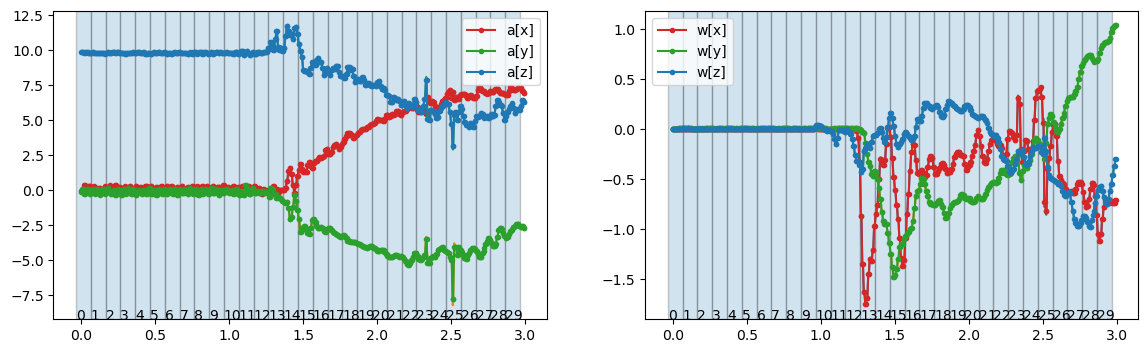

In [3]:
import matplotlib.pyplot as plt

n = min(len(timestamps), 600)
nl = n // 20
ts = np.linspace(timestamps[0], timestamps[n-1], 10*n)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(ts, linear_interp(ts)[:,0])
ax1.plot(timestamps[:n], linear_accelerations[:n,0], 'C3.-', label='a[x]')
ax1.plot(ts, linear_interp(ts)[:,1])
ax1.plot(timestamps[:n], linear_accelerations[:n,1], 'C2.-', label='a[y]')
ax1.plot(ts, linear_interp(ts)[:,2])
ax1.plot(timestamps[:n], linear_accelerations[:n,2], 'C0.-', label='a[z]')
for i in range(nl):
    tr = get_cloud_time(livox_lidar[i])
    ax1.axvspan(tr[0], tr[-1], lw=1, alpha=0.2, edgecolor='k')
    ax1.annotate(str(i), (tr[0], ax1.get_ylim()[0]))
ax1.legend()
ax2.plot(ts, angular_interp(ts)[:,0])
ax2.plot(timestamps[:n], angular_velocities[:n,0], 'C3.-', label='w[x]')
ax2.plot(ts, angular_interp(ts)[:,1])
ax2.plot(timestamps[:n], angular_velocities[:n,1], 'C2.-', label='w[y]')
ax2.plot(ts, angular_interp(ts)[:,2])
ax2.plot(timestamps[:n], angular_velocities[:n,2], 'C0.-', label='w[z]')
for i in range(nl):
    tr = get_cloud_time(livox_lidar[i])
    ax2.axvspan(tr[0], tr[-1], lw=1, alpha=0.2, edgecolor='k')
    ax2.annotate(str(i), (tr[0], ax2.get_ylim()[0]))
ax2.legend()
plt.show()

Integrate for local velocity

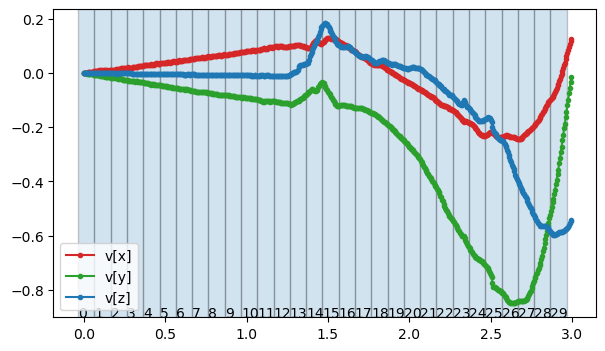

In [4]:
def exp_so3(phi):
    theta = np.linalg.norm(phi)
    if theta == 0.0:
        return np.eye(3)
    n = phi / theta
    nnT = np.outer(n, n)
    n_star = np.array([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    R = np.cos(theta) * np.eye(3) + \
        (1.0-np.cos(theta)) * nnT + \
        np.sin(theta) * n_star
    assert np.linalg.norm(R@R.T-np.eye(3)) < 1e-12
    return R

vg = np.zeros(3)
R = np.eye(3)
prev_t = timestamps[0]
linear_velocities = [vg]
for t, al, wl in zip(timestamps[1:], linear_accelerations[1:], angular_velocities[1:]):
    n_step = 1
    for i in range(n_step):
        ag = R @ al - [0,0,9.81]
        wg = R @ wl
        dt = (t-prev_t)/n_step
        vg = vg + ag * dt
        R = exp_so3(wl*dt) @ R
    vl = R.T @ vg
    linear_velocities.append(vl)
    prev_t = t
linear_velocities = np.array(linear_velocities)


fig, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(timestamps[:n], linear_velocities[:n,0], 'C3.-', label='v[x]')
ax1.plot(timestamps[:n], linear_velocities[:n,1], 'C2.-', label='v[y]')
ax1.plot(timestamps[:n], linear_velocities[:n,2], 'C0.-', label='v[z]')
for i in range(nl):
    tr = get_cloud_time(livox_lidar[i])
    ax1.axvspan(tr[0], tr[-1], lw=1, alpha=0.2, edgecolor='k')
    ax1.annotate(str(i), (tr[0], ax1.get_ylim()[0]))
ax1.legend()
plt.show()

Downsample point cloud

In [5]:
from plyfile import PlyData, PlyElement

def write_point_cloud(points, filename):
    vertex = np.array([(x, y, z) for x, y, z in points], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
    vertex_element = PlyElement.describe(vertex, 'vertex')
    PlyData([vertex_element], text=False).write(filename)


def downsample_point_cloud_with_time(times, points):

    bmax = np.amax(points, 0)
    bmin = np.amin(points, 0)
    bbox_size = bmax - bmin
    size = np.prod(bbox_size)**(1/3)

    voxel_size = np.fmax((120*bbox_size/size+0.5).astype(np.int32), 1)
    # print(voxel_size)
    pids = -1 * np.ones(voxel_size, dtype=np.int32)
    pdists = np.inf * np.ones(voxel_size, dtype=np.float32)

    for i, p in enumerate(points):
        g = (p-bmin)/(bmax-bmin) * voxel_size
        g = np.fmin(g, voxel_size-0.001)
        gi = g.astype(np.int32)
        gd = np.linalg.norm(g-gi-0.5)
        if gd < pdists[gi[0], gi[1], gi[2]]:
            pids[gi[0], gi[1], gi[2]] = i
            pdists[gi[0], gi[1], gi[2]] = gd

    times1 = []
    points1 = []
    for p0, p1, p2 in zip(*np.where(pids >= 0)):
        i = pids[p0, p1, p2]
        times1.append(times[i])
        points1.append(points[i])
    return np.array(times1), np.array(points1)


def get_cloud(lidar_msg, id=-1, sort=True):
    points = sorted(lidar_msg.points, key=lambda _: _.offset_time)
    time_start = lidar_msg.header.stamp.to_sec()
    times = 1e-9 * np.array([p.offset_time for p in points])
    points = np.array([(p.x, p.y, p.z) for p in points])
    if id >= 0:
        write_point_cloud(points, "{:04d}-raw.ply".format(id))
    # print(times.shape, points.shape)
    times_d, points_d = downsample_point_cloud_with_time(times, points)
    # print(times.shape, points.shape)
    if id >= 0:
        write_point_cloud(points, "{:04d}-raw.ply".format(id))
        write_point_cloud(points_d, "{:04d}-downsampled.ply".format(id))
        # print cloud shape to see if it's right
        mean = np.mean(points_d, axis=0)
        cov = np.linalg.svd(np.cov(points_d.T))[1]**0.5
        print(id, mean, cov)
    
    if sort:
        i = np.argsort(times_d)
        times_d, points_d = times_d[i], points_d[i]
    return times_d, points_d


_ = get_cloud(livox_lidar[1], 1)
_ = get_cloud(livox_lidar[12], 12)
_ = get_cloud(livox_lidar[13], 13)
_ = get_cloud(livox_lidar[14], 14)
_ = get_cloud(livox_lidar[18], 18)
_ = get_cloud(livox_lidar[29], 29)


1 [-0.63462617 -0.12941414  1.71955218] [2.82366347 2.23324904 1.06722564]
12 [-0.15407046 -0.34527914  1.84173474] [2.54475285 2.12295994 0.96927754]


13 [-0.23961829 -0.76144558  1.88428435] [2.63051597 2.21665854 0.96800286]
14 [-0.16721852 -1.08113515  1.86454983] [2.75464092 2.27618397 1.01304785]
18 [ 0.16089352 -1.40001063  1.79924651] [3.08247487 2.3443156  1.1442621 ]
29 [ 0.95786526 -0.64736638  1.56281731] [2.2453438  2.04737113 0.87347909]


Visualize LiDAR scan, Livox Mid360 for this example

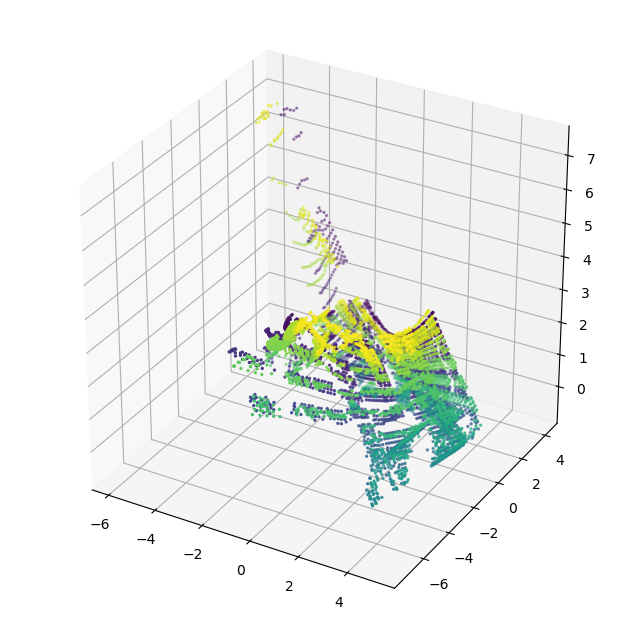

/tmp/ipykernel_189463/879646765.py:16: RuntimeWarning: invalid value encountered in divide
  es = ps / ls.reshape((-1, 1))


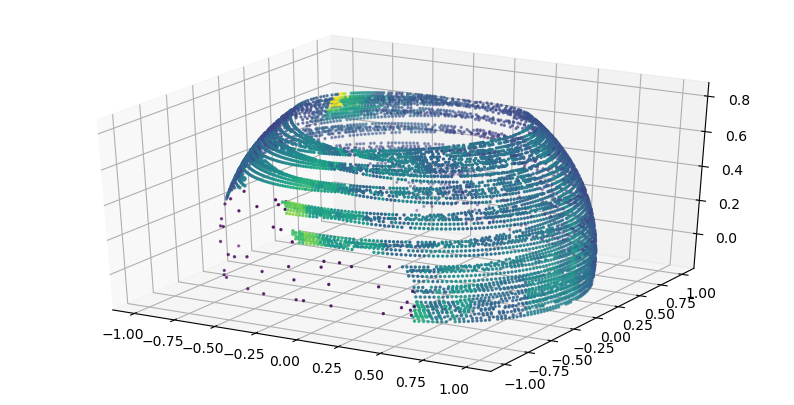

In [6]:
# times, points = get_cloud(livox_lidar[10])
ts, ps = get_cloud(livox_lidar[29])

# plt.figure()
# plt.hist(times[1:]-times[:-1], 200)
# plt.yscale('log')
# plt.show()

from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
ax.scatter(ps[:,0], ps[:,1], ps[:,2], s=2, c=ts, cmap=plt.get_cmap('viridis'))
plt.show()


ls = np.linalg.norm(ps, axis=1)
es = ps / ls.reshape((-1, 1))

ax = plt.figure(figsize=(10,5)).add_subplot(projection='3d')
ax.scatter(es[:,0], es[:,1], es[:,2], s=2, c=ls, cmap=plt.get_cmap('viridis'))
plt.show()

Undistortion idea:

For a LiDAR, local frame direction $\hat{e}$

Point $p=R(r\hat{e}+x)$, $R^{-1}p-x=r\hat{e}$

Consider two points with same directions, $p_{i1}/r_{i1}=p_{i2}/r_{i2}=\hat{e}_i$, at time $t_{i1}$, $t_{i2}$

Assume undistorted initially, linearize $R^{-1}_{ij}=\exp(-\omega^\land t_{ij})$, $x_{ij}=vt_{ij}$

Find pairs of points with very close directions $\hat{e}_i$, $\exp(-\omega^\land t_{ij})(p_{ij}-vt_{ij})=r_i\hat{e}_i$, minimize for $\omega$, $v$, $r_i$

--------

Doesn't work, overlooked that $\hat{e}_i$ changes with rotation; Ended up using IMU

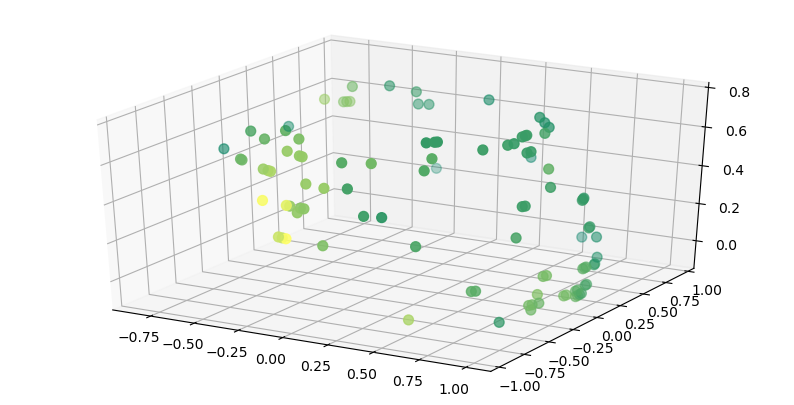

In [7]:
from scipy.spatial import cKDTree

def query_closest_points(points, N):
    tree = cKDTree(points)
    closest_pairs = []
    for i, point in enumerate(points):
        dists, indices = tree.query(point, k=5)
        for d, j in zip(dists[1:], indices[1:]):
            if i < j:
                closest_pairs.append((d, i, j))
    closest_pairs.sort(key=lambda _: _[0])
    return ([_[1] for _ in closest_pairs[:N]],
            [_[2] for _ in closest_pairs[:N]])

ts, ps = get_cloud(livox_lidar[29])
ls = np.fmax(np.linalg.norm(ps, axis=1), 1e-12)
es = ps / ls.reshape((-1, 1))
i1, i2 = query_closest_points(es, 100)

ax = plt.figure(figsize=(10,5)).add_subplot(projection='3d')
ax.scatter(es[i1,0], es[i1,1], es[i1,2], s=50, c=ls[i1], cmap=plt.get_cmap('summer'))
# ax.scatter(es[i2,0], es[i2,1], es[i2,2], s=50, c=ls[i2], cmap=plt.get_cmap('winter'))
plt.show()

mean dt: 0.04867138438
v: [0.02769897 0.33691456 0.5887267 ]
w: [ 0.85491951 -0.84284399  0.64505655]
rmse before: 0.23844657693720353
(nfev, njev): 4 4
rmse after: 0.13641610630595385
v: [ 1.32435231 -0.19980001 -0.94916003]
w: [-0.12519217 -0.35165666 -0.02541528]


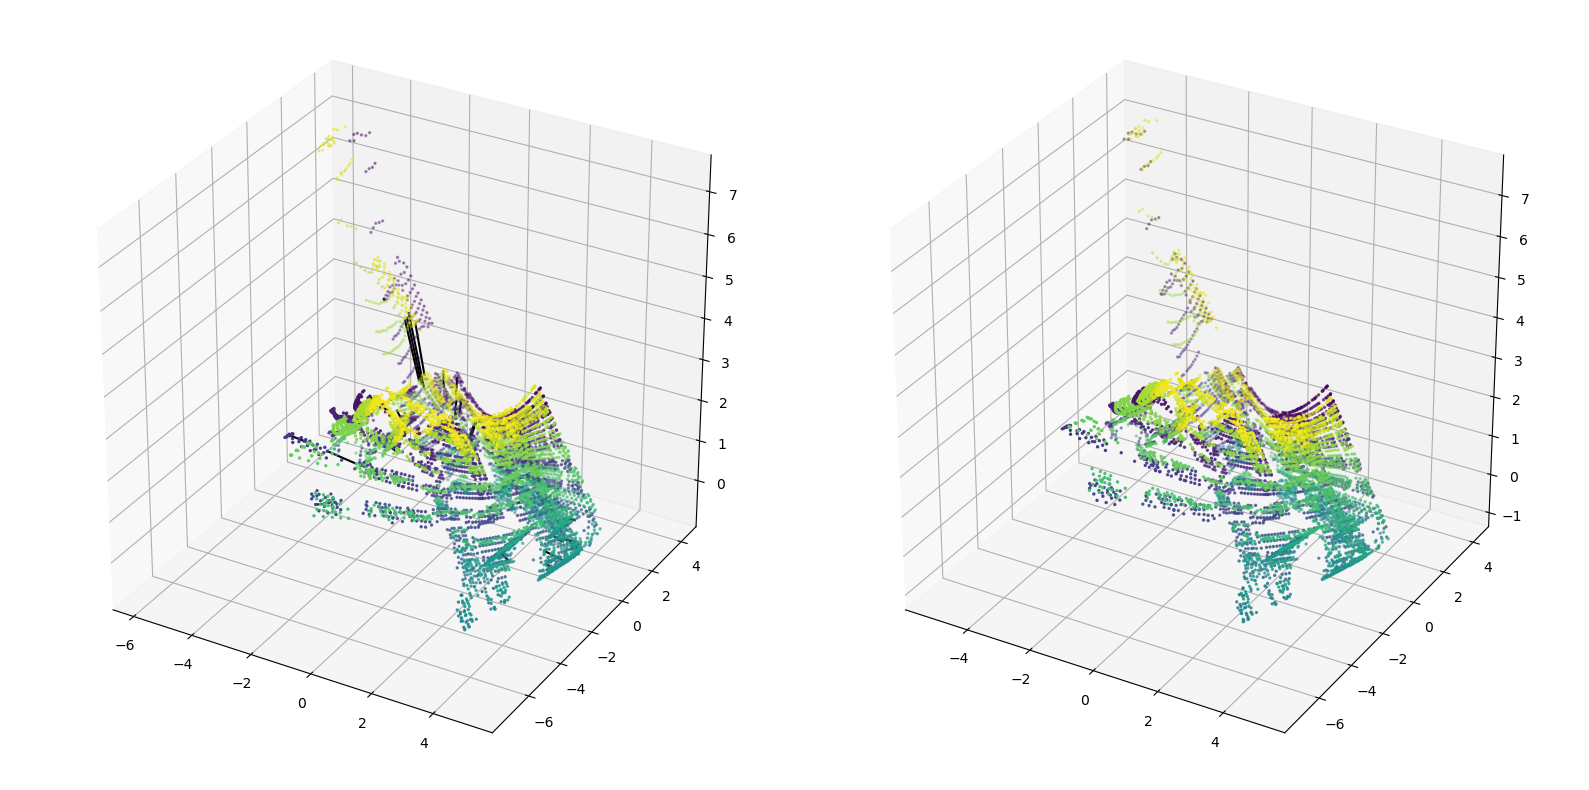

In [8]:
import scipy.optimize


scan = livox_lidar[29]
ts = get_cloud_time(scan)
imu_i = np.where((timestamps >= min(ts)) & (timestamps <= max(ts)))

ts, ps = get_cloud(scan)
ls = np.fmax(np.linalg.norm(ps, axis=1), 1e-12)
es = ps / ls.reshape((-1, 1))
i1, i2 = query_closest_points(es, 100)
n = len(i1)
t1s, t2s = ts[i1], ts[i2]
print('mean dt:', np.mean(t2s-t1s))
p1s, p2s = ps[i1], ps[i2]
e1s, e2s = es[i1], es[i2]


def fun(params):
    v = params[0:3]
    w = params[3:6]
    rs = params[6:].reshape((-1,1))
    R1s = np.array([exp_so3(-w*t1) for t1 in t1s])
    R2s = np.array([exp_so3(-w*t2) for t2 in t2s])
    res1 = np.einsum('kij,kj->ki', R1s, p1s-np.outer(t1s,v)) - rs*e1s
    res2 = np.einsum('kij,kj->ki', R2s, p2s-np.outer(t2s,v)) - rs*e2s
    return np.concatenate((res1, res2), axis=1).flatten()


v_guess = -np.mean(linear_velocities[imu_i], axis=0)
w_guess = -np.mean(angular_velocities[imu_i], axis=0)
print('v:', v_guess)
print('w:', w_guess)
params_guess = np.concatenate((v_guess, w_guess, np.linalg.norm(p1s, axis=1)))
fun(params_guess).shape

jac_sp = scipy.sparse.lil_matrix((6*n, n+6), dtype=int)
jac_sp[:, :6] = 1
for i in range(n):
    jac_sp[6*i:6*i+6, i+6:i+7] = 1

print('rmse before:', np.mean(fun(params_guess)**2)**0.5)
res = scipy.optimize.least_squares(
    fun, params_guess, jac_sparsity=jac_sp,
    verbose=0, x_scale='jac', ftol=1e-4, method='trf')
print('(nfev, njev):', res.nfev, res.njev)
print('rmse after:', np.mean(res.fun**2)**0.5)

v = res.x[0:3]
w = res.x[3:6]
print('v:', v)
print('w:', w)
v, w = v_guess, w_guess

# %matplotlib tk
# %matplotlib

Rs = np.array([exp_so3(-w*t) for t in ts])
us = np.einsum('kij,kj->ki', Rs, ps-np.outer(ts,v))

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter(ps[:,0], ps[:,1], ps[:,2], s=2, c=ts, cmap=plt.get_cmap('viridis'))
# ax1.scatter(ps[i1,0], ps[i1,1], ps[i1,2], s=50, c='r')
# ax1.scatter(ps[i2,0], ps[i2,1], ps[i2,2], s=50, c='b')
for p1, p2 in zip(ps[i1], ps[i2]):
    ax1.plot([p1[0],p2[0]], [p1[1],p2[1]], [p1[2],p2[2]], 'k-')
ax2.scatter(us[:,0], us[:,1], us[:,2], s=2, c=ts, cmap=plt.get_cmap('viridis'))
plt.tight_layout()
plt.show()
